# Hand Gesture Recognition

The American Sign Language letter database of hand gestures represent a multi-class problem with 24 classes of letters (excluding J and Z which require motion).

The dataset format is patterned to match closely with the classic MNIST. Each training and test case represents a label (0-25) as a one-to-one map for each alphabetic letter A-Z (and no cases for 9=J or 25=Z because of gesture motions). The training data (27,455 cases) and test data (7172 cases) are approximately half the size of the standard MNIST but otherwise similar with a header row of label, pixel1,pixel2….pixel784 which represent a single 28x28 pixel image with grayscale values between 0-255. The original hand gesture image data represented multiple users repeating the gesture against different backgrounds. The Sign Language MNIST data came from greatly extending the small number (1704) of the color images included as not cropped around the hand region of interest. To create new data, an image pipeline was used based on ImageMagick and included cropping to hands-only, gray-scaling, resizing, and then creating at least 50+ variations to enlarge the quantity. The modification and expansion strategy was filters ('Mitchell', 'Robidoux', 'Catrom', 'Spline', 'Hermite'), along with 5% random pixelation, +/- 15% brightness/contrast, and finally 3 degrees rotation. Because of the tiny size of the images, these modifications effectively alter the resolution and class separation in interesting, controllable ways.

This dataset was inspired by the Fashion-MNIST 2 

## Library Imports

In [30]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

print(f"Libraries Imported!!")

Libraries Imported!!


## Global Functions

In [31]:
'''
Function to shown an image based 
'''
def show_img(img_number, df):
    #  extract the label for the image number
    label = df['label'][img_number]
    # extract all the pixels for the image number
    pixels = df.iloc[img_number, 1:]
    # convert to numpy array
    pixels = np.array(pixels, dtype='uint8')
    pixels = pixels.reshape((28, 28))

    # Now we will plot the image
    plt.title(f"Label is {label}")
    plt.imshow(pixels, cmap='gray')
    plt.show()

## Load the data

In [32]:
PARENT_DIR = os.environ.get("ONE_DRIVE")
DATA_DIR = 'Datasets/GuidedProjects'
DATA_DIR = Path(os.path.join(PARENT_DIR, DATA_DIR))

data_train = pd.read_csv(DATA_DIR/'sign_mnist_train.csv')
data_test = pd.read_csv(DATA_DIR/'sign_mnist_test.csv')

# Check the data load for training dataset
data_train.head(3)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195


In [33]:
# Check first three rows of the test dataset

data_test.head(3)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222


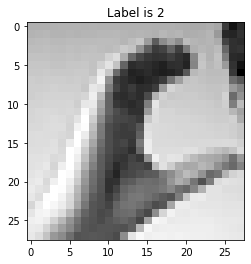

In [34]:
# Now display the image number 20 from the test dataset
show_img(20, data_test)

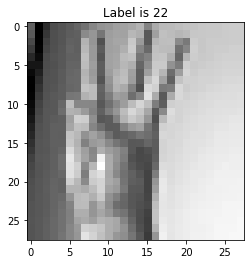

In [35]:
# Now display the image number 7 from the train dataset
show_img(7, data_train)

## Data Preparation

To increase the performance of training.. but increasing the amount of data by adding slightly modified copies of the data

### Seggregate between training and testing values

In [36]:
y_train = data_train['label']
y_test = data_test['label']

# We will use label binarizer
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

In [37]:
# Extract the features
x_train = data_train.drop(labels='label', axis=1).values
x_test = data_test.drop(labels='label', axis=1).values

# Normalize the values
x_train = x_train/255.0
x_test = x_test/255.0

In [38]:
# We will do the reshaping for Neural Network Modelling
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

## Data Augmentation

### Building the augmentation function and fit on training data

In [39]:
data_generator = ImageDataGenerator(
    featurewise_center=False,  # If True, input mean will be set to 0, all features to be centered
    samplewise_center=False, # If True, sample mean will be set to 0, all features to be centered
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    # A linear algebra operation, which reduces redundancy in images. Reduced redundancy, allows clear highlights of features
    # Useful in cases where the images do not have clear background
    # In our current dataset, the background is clean
    zca_whitening=False,
    rotation_range=10, # Rotates the images at random between 0 - 180 degrees
    zoom_range=0.1, # zoom into the image at random
    width_shift_range=0.1, # This is going to shift the image horizontally and randomly
    height_shift_range=0.1, # This is going to shift the image vertically and randomly
    horizontal_flip=False,
    vertical_flip=False
)

# Now we will fit the data on the training set
data_generator.fit(x_train)

## Building the Model

In [40]:
# Build the model

model = Sequential([
    Conv2D(filters=75, kernel_size=(3, 3), strides=1, padding='same', activation=tf.nn.relu, input_shape=x_train.shape[1:]),
    BatchNormalization(), # Allows the neural network to train faster
    MaxPool2D(pool_size=(2,2), strides=2, padding='same'), # will downsize the sample by taking the max of the features
    Conv2D(filters=50, kernel_size=(3, 3), strides=1, padding='same', activation=tf.nn.relu),
    Dropout(rate=0.2),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2), strides=2, padding='same'),
    Conv2D(filters=25, kernel_size=(3, 3), strides=1, padding='same', activation=tf.nn.relu),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2), strides=2, padding='same'),
    Flatten(),
    Dense(units=512, activation=tf.nn.relu),
    Dropout(rate=0.3),
    Dense(units=24, activation=tf.nn.softmax)
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 75)        750       
_________________________________________________________________
batch_normalization_3 (Batch (None, 28, 28, 75)        300       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 75)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 50)        33800     
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 50)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 14, 14, 50)        200       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 50)         

## Training the Model

In [41]:
# set learning rate

# This reduces the learning rate when a metric has stopped improving. The model performance improves by reducing the learning rate.
# This should only be done if the learning rate stagnates
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.5, # learning rate should be reduced by a factor of 50%
                                            min_lr=0.00001) # min_lr is the lower boundary for the learning rate

In [42]:
# train the model
model.fit(data_generator.flow(x_train, y_train, batch_size=128), epochs=20, validation_data=(x_test, y_test),
          callbacks=[learning_rate_reduction])

2022-01-24 15:57:11.833818: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/20
215/215 [==============================] - 44s 202ms/step - loss: 1.7224 - accuracy: 0.4836 - val_loss: 2.9695 - val_accuracy: 0.2167
Epoch 2/20
215/215 [==============================] - 43s 200ms/step - loss: 0.2485 - accuracy: 0.9164 - val_loss: 1.3139 - val_accuracy: 0.5393
Epoch 3/20
215/215 [==============================] - 43s 200ms/step - loss: 0.1090 - accuracy: 0.9649 - val_loss: 0.0390 - val_accuracy: 0.9961
Epoch 4/20
215/215 [==============================] - 43s 201ms/step - loss: 0.0667 - accuracy: 0.9786 - val_loss: 0.0161 - val_accuracy: 0.9985
Epoch 5/20
215/215 [==============================] - 44s 204ms/step - loss: 0.0449 - accuracy: 0.9847 - val_loss: 0.0522 - val_accuracy: 0.9830
Epoch 6/20
215/215 [==============================] - 44s 204ms/step - loss: 0.0382 - accuracy: 0.9879 - val_loss: 0.0582 - val_accuracy: 0.9769

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/20
215/215 [=============================

In [43]:
# Check the final accuracy
model.evaluate(x_test, y_test)

225/225 [==============================] - 4s 19ms/step - loss: 7.8177e-04 - accuracy: 0.9999


[0.0007817685836926103, 0.9998605847358704]

## Obtain Predictions

In [47]:
# we will run the predictions
predictions = model.predict_classes(x_test)

for index in range(len(predictions)):
    if (predictions[index] >= 9 or predictions[index] >= 25):
        # Both the alphabets J and Z needs hand movement and we dont have any images for them in the dataset
        # Therefore we are incrementing the value
        predictions[index] += 1

# Check the first 5 values
predictions[:5]

array([ 6,  5, 10,  0,  3])

In [49]:
# Save the model
model.save('hand_gesture.h5')